# Predicting sentiment from product reviews


The goal of this first notebook is to explore logistic regression and feature engineering with existing Scikit-Learn functions.

In this notebook you will use product review data from Amazon.com to predict whether the sentiments about a product (from its reviews) are positive or negative.

* Use Pandas to do some feature engineering
* Train a logistic regression model to predict the sentiment of product reviews.
* Inspect the weights (coefficients) of a trained logistic regression model.
* Make a prediction (both class and probability) of sentiment for a new product review.
* Given the logistic regression weights, predictors and ground truth labels, write a function to compute the **accuracy** of the model.
* Inspect the coefficients of the logistic regression model and interpret their meanings.
* Compare multiple logistic regression models.

Let's get started!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

### 1. Load and Explore Data

In [2]:
products = pd.read_csv("../../ML Data & Script/amazon_baby.csv")
products.head(5)

,name,review,rating
0,Planetwise Flannel Wipes,"These flannel wipes are OK, but in my opinion ...",3
1,Planetwise Wipe Pouch,it came early and was not disappointed. i love...,5
2,Annas Dream Full Quilt with 2 Shams,Very soft and comfortable and warmer than it l...,5
3,Stop Pacifier Sucking without tears with Thumb...,This is a product well worth the purchase. I ...,5
4,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5


In [3]:
# how many rows
products.shape

(183531, 3)

In [4]:
# classes
count_classes = products.rating.value_counts().sort_index()
count_classes

1     15183
2     11310
3     16779
4     33205
5    107054
Name: rating, dtype: int64

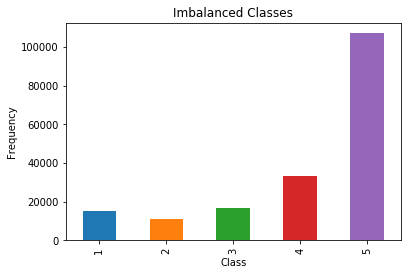

In [5]:
# plot classes count
count_classes.plot(kind = 'bar')
plt.title("Imbalanced Classes")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

In [6]:
# nulls?
products.isna().sum()

name      318
review    829
rating      0
dtype: int64

In [7]:
# only drop rows if review is missing
products = products[pd.notnull(products.review)]
products.isna().sum()

name      318
review      0
rating      0
dtype: int64

In [8]:
# replace missing names with empty string
products = products.fillna('')
products.isna().sum()

name      0
review    0
rating    0
dtype: int64

In [9]:
# see the length of the reviews(word count)
products['length'] = products['review'].str.len()
products[['review', 'length']].head()
products.drop('length',axis=1, inplace=True)

### 2. Data Preparation: Cleaning, Scaling, Feature Engineering,

In [10]:
# remove rating of 3
products = products[products['rating'] != 3]
# convert rating to binary sentiment
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [11]:
# remove punctuation and create word-count vector
# regex patterns searches one character which is neither word character nor space
products['review'] = products['review'].str.replace('[^\w\s]','')

See https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/

In [12]:
X = products.iloc[:,:-1]
y = products['sentiment']

In [13]:
# create train-test split first
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8 , test_size=0.2, shuffle=True)

In [14]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
# Use this token pattern to keep single-letter words
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
matrix_train = vectorizer.fit_transform(X_train['review'])
# the test set is vectorized using the vocabulary learned from the training data
matrix_test = vectorizer.transform(X_test['review'])
print(matrix_train.shape)
print(matrix_test.shape)

(132780, 121769)
(33195, 121769)


In [16]:
X_train.head()

,name,review,rating
0,"Withings Smart Baby Monitor, White",My wife and I purchased the Wiithings Smart Ba...,1
1,Infantino Couple a Spoons,I Use them daily they so easy to use with the ...,4
2,"Simple Wishes Hands-Free Breastpump Bra, Pink,...",I recently bought this to use for pumping for ...,5
3,Thermos Foogo Leak-Proof Stainless Steel 10-Ou...,I bought one in blue and one in pink I followe...,5
4,Kate Aspen Set of 4 Victorian Style Key Place ...,Beautiful set of place card holders Ordered 24...,5


In [17]:
# proving that vocabulary_ is a dictioanry, so it is not sorted in memory
vocabulary = vectorizer.vocabulary_
keys = list(vocabulary.keys())[0:10]
{k: vocabulary[k] for k in keys}

{'my': 69984,
 'wife': 119029,
 'and': 10626,
 'i': 54466,
 'purchased': 85082,
 'the': 106285,
 'wiithings': 119086,
 'smart': 97301,
 'baby': 13700,
 'monitor': 68326}

In [18]:
# feature names for the sparse matrix(very useful)
# showing only samples
feature_names = vectorizer.get_feature_names()[100000:100010]
feature_names

['spunkys',
 'spurge',
 'spurofthemoment',
 'spurred',
 'spurs',
 'spurt',
 'spurt3',
 'spurtit',
 'spurts',
 'sput']

### 3. Train a Model

In [19]:
from sklearn.linear_model import LogisticRegression
sentiment_model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs')
sentiment_model.fit(matrix_train, y_train)

C:\Users\Tinsae\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
print(sentiment_model.coef_)
print(sentiment_model.intercept_)

[[-0.44150305  0.00129059  0.00309939 ...  0.00144408  0.00087786
  -0.00045869]]
[1.30231945]


In [21]:
# see cofficients shape
print(sentiment_model.coef_[0].shape)

(121769,)


In [22]:
# count negative and positive cofficients
negatives = sum(1 for i in sentiment_model.coef_[0] if i < 0)
positives = sum(1 for i in sentiment_model.coef_[0] if i > 0)
zeros = sum(1 for i in sentiment_model.coef_[0] if i == 0)
print("negative cofficeints ", negatives)
print("zeros", zeros)
print("positive cofficeints ", positives)

negative cofficeints  32060
zeros 0
positive cofficeints  89709


In [23]:
sentiment_model.coef_[0].shape[0] == positives + negatives + zeros

True

In [24]:
matrix_test[10:13].toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 4. Predict

In [25]:
sample_test_matrix = matrix_test[10:13].toarray()
print(sample_test_matrix)
print("true labels for sample test data")
print(y_test[10:13])
print("sample test data")
X_test[10:13]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
true labels for sample test data
10    1
11    1
12   -1
Name: sentiment, dtype: int64
sample test data


,name,review,rating
10,Bumble Bags Kimberly Tote Bag Blue Latte,I feel very stylish carrying this bag Its very...,5
11,"Regalo Easy Step Walk Thru Gate, White",I bought two because I have small dogs They we...,4
12,Safety 1st Foam Corner Bumpers,Awful Wouldnt stay affixed to the corners of ...,1


In [26]:
# see all the reviews of the sample data
pd.set_option('display.max_colwidth', 300)
print(X_test[10:11]['review'].values[0])
print()
print(X_test[11:12]['review'].values[0])
print()
print(X_test[12:13]['review'].values[0])

I feel very stylish carrying this bag Its very wellconstructed and beautiful to carry around

I bought two because I have small dogs They were easy to install and look much better than the baby gates that I was using

Awful  Wouldnt stay affixed to the corners of our counter tops  Lasted less than a week before we abandoned them altogether


In [27]:
scores = sentiment_model.decision_function(sample_test_matrix)
# the scores show the confidence in prediction(or the output of the linear function)
scores

array([ 3.86476703,  3.89988321, -3.7134911 ])

score (sometimes called margin) for the logistic regression model is defined as:

$$
\mbox{score}_i = \mathbf{w}^T h(\mathbf{x}_i)
$$ 

These scores can be used to make class predictions as follows:

$$
\hat{y} = 
\left\{
\begin{array}{ll}
      +1 & \mathbf{w}^T h(\mathbf{x}_i) > 0 \\
      -1 & \mathbf{w}^T h(\mathbf{x}_i) \leq 0 \\
\end{array} 
\right.
$$

In [28]:
#  make prediction based on this function
np.where(scores > 0, 1, -1)

array([ 1,  1, -1])

In [29]:
sentiment_model.predict(sample_test_matrix)

array([ 1,  1, -1], dtype=int64)

##### Probability Predictions

In [30]:
import math

prob=[0.,0.,0.]
for i in range(3):
    prob[i]=1/(1+math.exp(-scores[i]))
print("probabilities obtained by calculation" ,prob)

probabilities obtained by calculation [0.9794628130308736, 0.9801574228741736, 0.02381140567907209]


##### Find the most positive (and negative) review

To calculate these top-20 reviews, use the following steps:

Make probability predictions on test_data using the sentiment_model.
Sort the data according to those predictions and pick the top 20.

In [31]:
probs_test = sentiment_model.predict_proba(matrix_test)
probs_test

array([[1.13384713e-02, 9.88661529e-01],
       [4.91689804e-03, 9.95083102e-01],
       [4.69645701e-02, 9.53035430e-01],
       ...,
       [9.55958869e-01, 4.40411312e-02],
       [5.82628791e-07, 9.99999417e-01],
       [4.68603009e-02, 9.53139699e-01]])

The probabilities on each row sum up to 1.

In [32]:
# this is the ordering of the classes
sentiment_model.classes_

array([-1,  1], dtype=int64)

In [33]:
# sort in ascending order, reverse, slice top 20
top_negative = probs_test[:,0].argsort()[::-1][:20]
top_positive = probs_test[:,1].argsort()[::-1][:20]

In [34]:
X_test.loc[top_negative,:]['review']

29955    First off I did manage to find this product for 20 less at the big box store than the price here Secondly this product is horribly manufactured  Absolute waste of money  The only thing Ill give it credit for is the assembly instruction sheet is as clear cut as Ive come across in assembleathome b...
9406     My disappointment with this product prompted me to write to the manufacturer  Below is my correspondenceIm writing you this email to express my deep dissatisfaction with a recently purchased Graco productMy wife and I are new parents and as expected the Graco brand was quite heavily represented ...
3734     I received this pump through insurance and I figured that free is always good  I was an idiot  I started pumping when my daughter turned one month old  For the first month or so this pump worked well  I was able to get many ounces in a fairly short period of time  I was pumping about twice a day...
13701    I had a frustrating experience with these two similar but differ

In [35]:
X_test.loc[top_negative,:]['review']

29955    First off I did manage to find this product for 20 less at the big box store than the price here Secondly this product is horribly manufactured  Absolute waste of money  The only thing Ill give it credit for is the assembly instruction sheet is as clear cut as Ive come across in assembleathome b...
9406     My disappointment with this product prompted me to write to the manufacturer  Below is my correspondenceIm writing you this email to express my deep dissatisfaction with a recently purchased Graco productMy wife and I are new parents and as expected the Graco brand was quite heavily represented ...
3734     I received this pump through insurance and I figured that free is always good  I was an idiot  I started pumping when my daughter turned one month old  For the first month or so this pump worked well  I was able to get many ounces in a fairly short period of time  I was pumping about twice a day...
13701    I had a frustrating experience with these two similar but differ

### 5: Test Model

In [36]:
sentiment_model.score(matrix_train, y_train)

0.9475523422202139

In [37]:
sentiment_model.score(matrix_test, y_test)

0.9325500828438018

### 6. Learn a Simpler Model

In [38]:
significant_words = ['love', 'great', 'easy', 'old', 'little', 'perfect', 'loves', 
      'well', 'able', 'car', 'broke', 'less', 'even', 'waste', 'disappointed', 
      'work', 'product', 'money', 'would', 'return']
# limit to 20 words
vectorizer_word_subset = CountVectorizer(vocabulary=significant_words) 
matrix_train2 = vectorizer_word_subset.fit_transform(X_train['review'])
matrix_test2 =  vectorizer_word_subset.transform(X_test['review'])

In [39]:
simple_model = LogisticRegression(C=1.0, penalty='l2', solver='lbfgs')
simple_model.fit(matrix_train2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [40]:
coffs_df= pd.DataFrame({"word feature":vectorizer_word_subset.get_feature_names(), "coefficeint":list(simple_model.coef_[0])})
coffs_df.sort_values(by="coefficeint", ascending=False).reset_index(drop=True)

,word feature,coefficeint
0,loves,1.719756
1,perfect,1.477999
2,love,1.341562
3,easy,1.165694
4,great,0.936116
5,little,0.506028
6,well,0.500638
7,able,0.209443
8,old,0.073578
9,car,0.071775


 Are the positive words in the simple_model also positive words in the sentiment_model?


In [41]:
# These are positive on simple model
positives = coffs_df[:10]['word feature'].values
feature_names = vectorizer.get_feature_names()
coffs_df[:10]['word feature']

0       love
1      great
2       easy
3        old
4     little
5    perfect
6      loves
7       well
8       able
9        car
Name: word feature, dtype: object

In [42]:
positives

array(['love', 'great', 'easy', 'old', 'little', 'perfect', 'loves',
       'well', 'able', 'car'], dtype=object)

In [43]:
len(feature_names)

121769

In [44]:
sentiment_model.coef_.shape

(1, 121769)

In [45]:
matrix_train.shape

(132780, 121769)

The coefficients of sentiment_model, the columns of the sparse vector(matrix_train) and the feature_names are aligned together. There are 121399 words in the vocabulary(used for sentiment model).

In [46]:
# get the indices of words in feature names
indices = [feature_names.index(w) for w in positives]
indices

[63702, 48970, 37732, 74230, 62742, 79032, 63778, 117963, 7519, 22281]

In [47]:
# check the indices
for i in indices:
    print(feature_names[i])

love
great
easy
old
little
perfect
loves
well
able
car


Perfect!!

In [48]:
# now let us see the coefficents

coffs_df['coeff_simple_model'] = list(sentiment_model.coef_[0][indices]) + ["-"]*10
coffs_df.head(10)

,word feature,coefficeint,coeff_simple_model
0,love,1.341562,1.46386
1,great,0.936116,1.19756
2,easy,1.165694,1.23236
3,old,0.073578,0.0279654
4,little,0.506028,0.599751
5,perfect,1.477999,1.65043
6,loves,1.719756,1.52038
7,well,0.500638,0.525098
8,able,0.209443,0.354654
9,car,0.071775,0.184556


These 10 features have positive coefficeints in both

### 7 : Compare Models

In [49]:
# training accuracy
print("sentiment_model", sentiment_model.score(matrix_train, y_train ))
print("simple_model", simple_model.score(matrix_train2, y_train))

sentiment_model 0.9475523422202139
simple_model 0.8673218858261786


In [52]:
# test accuracy
print("sentiment_model", sentiment_model.score(matrix_test, y_test))
print("simple_model", simple_model.score(matrix_test2, y_test))

sentiment_model 0.9325500828438018
simple_model 0.867178791986745


##### Majority Class Prediction

In [61]:
y_train.value_counts()[1] / np.sum(y_train.value_counts().values)

0.8412260882663052

In [63]:
y_train.value_counts()

 1    111698
-1     21082
Name: sentiment, dtype: int64

Both models are better than majority class prediction